<a href="https://colab.research.google.com/github/bnnair/MultiModal-RAG/blob/main/multi_modal_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install byaldi pdf2image qwen-vl-utils transformers

In [2]:
import requests
import os

pdfs = {
    # "Window": "https://www.westoxon.gov.uk/media/ksqgvl4b/10-design-guide-windows-and-doors.pdf",
    # "Roofs": "https://www.westoxon.gov.uk/media/d3ohnpd1/9-design-guide-roofs-and-roofing-materials.pdf",
    "Extensions": "https://www.westoxon.gov.uk/media/pekfogvr/14-design-guide-extensions-and-alterations.pdf",
    "Greener": "https://www.westoxon.gov.uk/media/thplpsay/16-design-guide-greener-traditional-buildings.pdf",
    "Sustainable": "https://www.westoxon.gov.uk/media/nk5bvv0v/12-design-guide-sustainable-building-design.pdf"
}

output_dir = "dataset"
os.makedirs(output_dir, exist_ok=True)

for name, url in pdfs.items():
    response = requests.get(url)
    pdf_path = os.path.join(output_dir, f"{name}.pdf")
    with open(pdf_path, "wb") as f:
        f.write(response.content)

After we download all the files, we transform all the PDF pages into images. Our multimodal document-retrieval model needs to work if it is to represent the document as an image.

In [3]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (218 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123635 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...


In [4]:
import os
from pdf2image import convert_from_path

def convert_pdfs_to_images(folder):
    pdf_files = [f for f in os.listdir(folder) if f.endswith('.pdf')]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(folder, pdf_file)
        images = convert_from_path(pdf_path, dpi=100)
        all_images[doc_id] = images

    return all_images

all_images = convert_pdfs_to_images("/content/dataset/")

All the documents will be transformed into an image file, so we can see their content in image format.

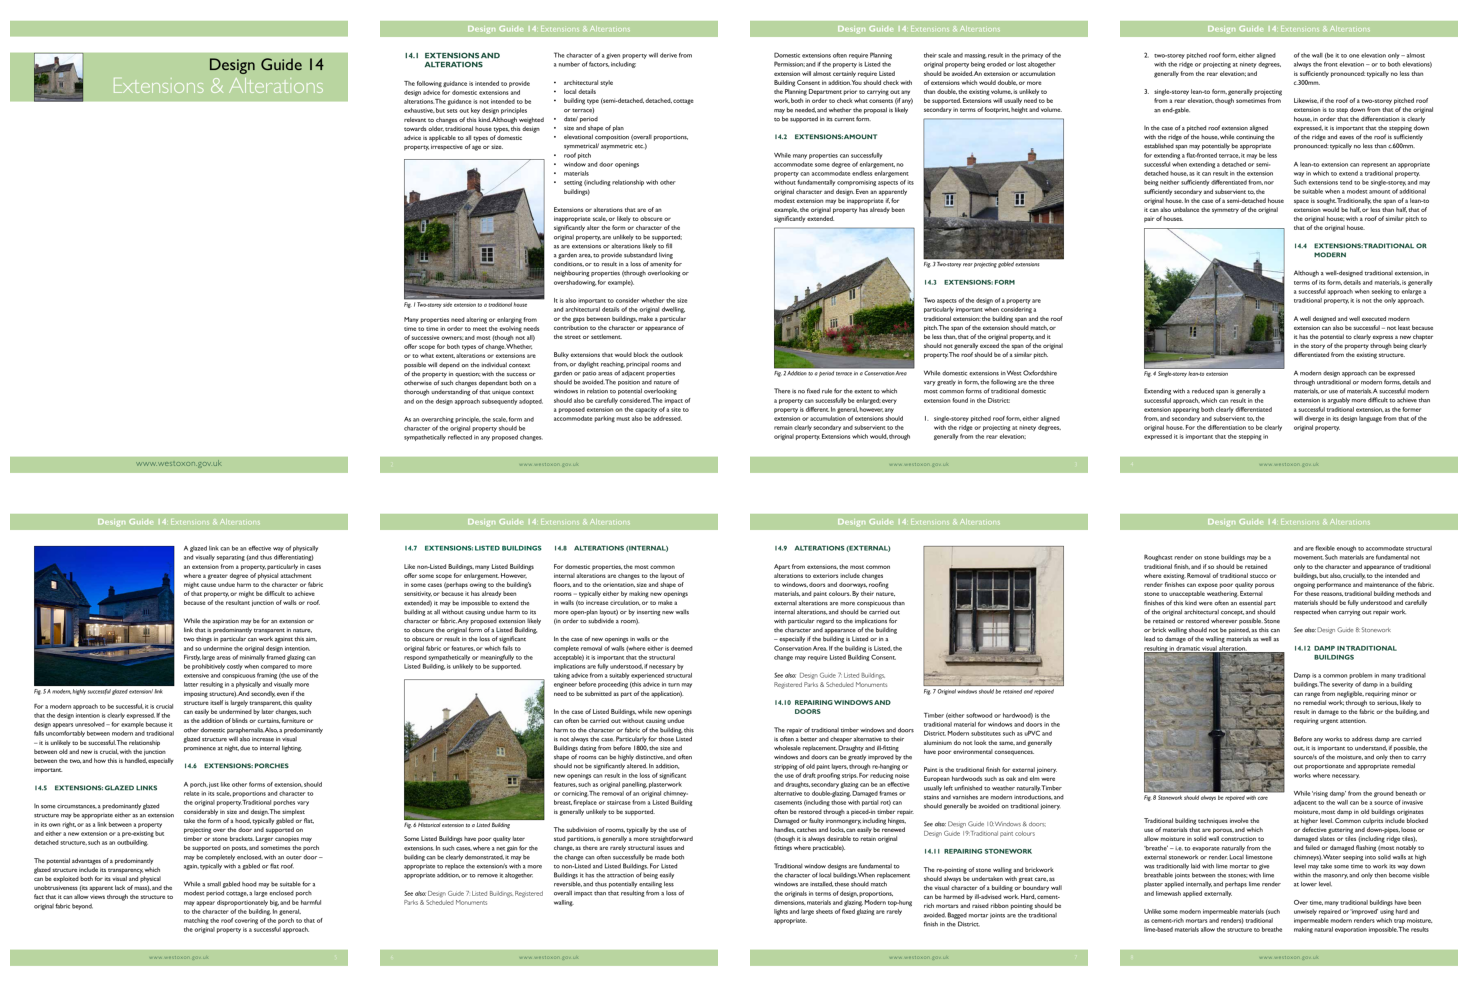

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = all_images[0][i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

Next, we will initialize the RAG system with Byaldi and the Document-Retrieval model ColPali. The ColPali model is a retrieval model that fetches the document by using the image directly instead of breaking it down into a text-chunking process.

We will use the Byaldi package, the ColPali simple wrapper, to facilitate the RAG implementation.

In [6]:
from byaldi import RAGMultiModalModel

colpali_model = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

When the model has been downloaded, we will use the following code to index our image data and build the Knowledge Base.

In [7]:
colpali_model.index(
    input_path="dataset/",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True
)

Indexing file: dataset/Extensions.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Index exported to .byaldi/image_index
Indexing file: dataset/Sustainable.pdf
Added page 1 of document 1 to index.
Added page 2 of document 1 to index.
Added page 3 of document 1 to index.
Added page 4 of document 1 to index.
Added page 5 of document 1 to index.
Added page 6 of document 1 to index.
Added page 7 of document 1 to index.
Added page 8 of document 1 to index.
Added page 9 of document 1 to index.
Added page 10 of document 1 to index.
Added page 11 of document 1 to index.
Added page 12 of document 1 to index.
Added page 13 of document 1 t

{0: 'dataset/Extensions.pdf',
 1: 'dataset/Sustainable.pdf',
 2: 'dataset/Greener.pdf'}

With the retrieval model ready, let’s try out how the model retrieves the documents from the text query.

In [8]:
query = "How should we design greener and sustainable house?"

results = colpali_model.search(query, k=2)
results

[{'doc_id': 1, 'page_num': 3, 'score': 12.1875, 'metadata': {}, 'base64': None},
 {'doc_id': 1, 'page_num': 11, 'score': 11.875, 'metadata': {}, 'base64': None}]

Let’s look at the documents retrieved from the above output.

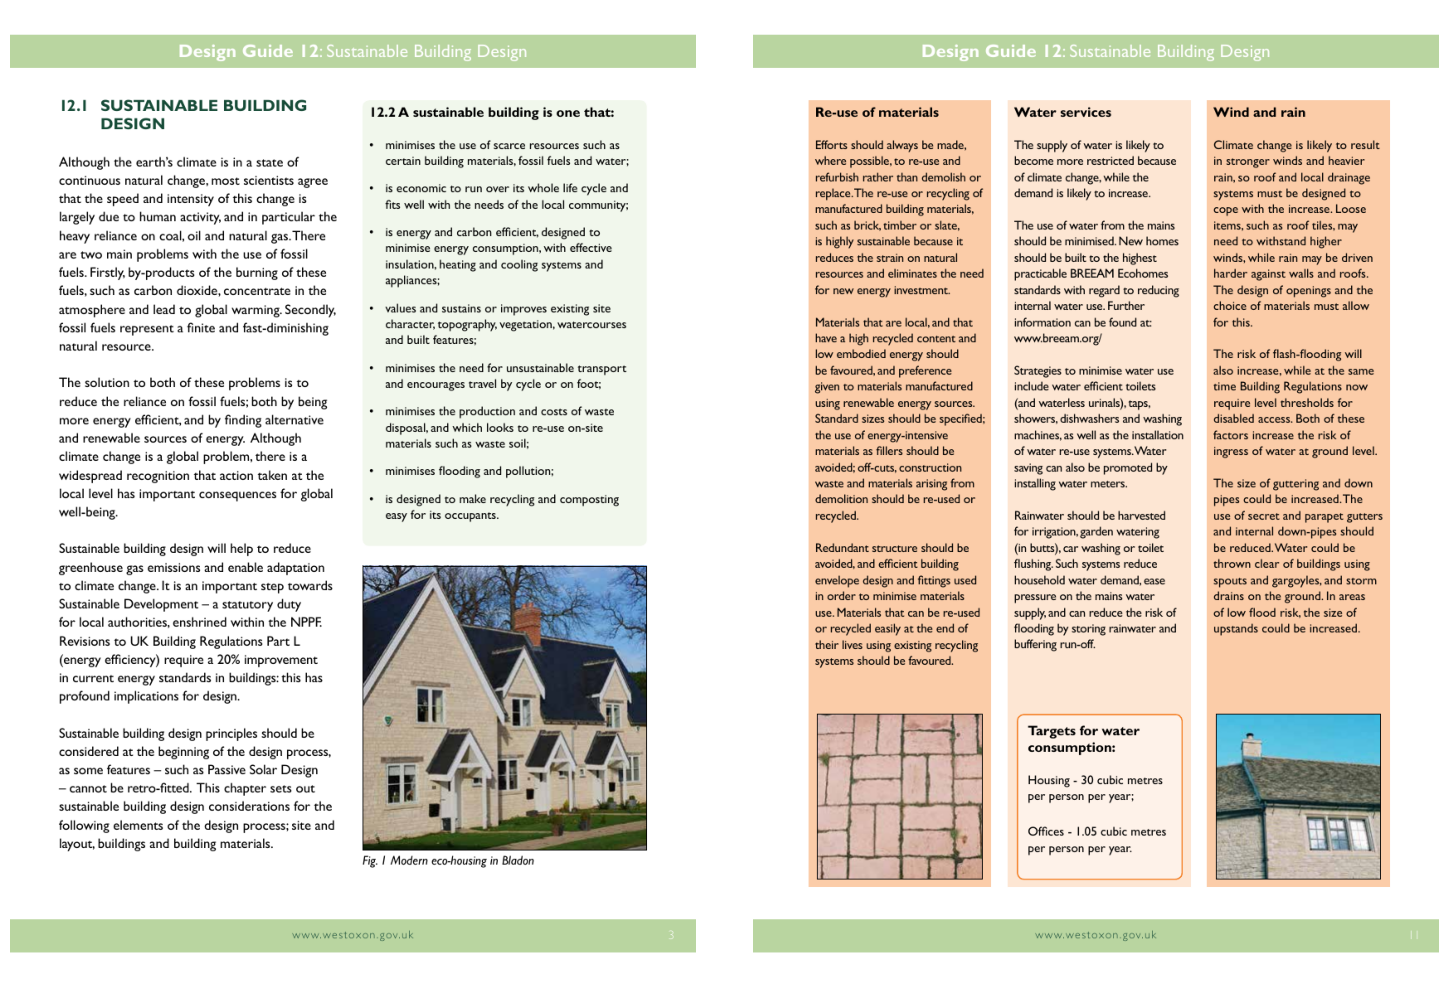

In [9]:
import matplotlib.pyplot as plt

def get_result_images(results, all_images):
    grouped_images = []

    for result in results:
        doc_id = result['doc_id']
        page_num = result['page_num']
        grouped_images.append(all_images[doc_id][page_num - 1])
    return grouped_images
result_images = get_result_images(results, all_images)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = result_images[i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

The retrieval model successfully retrieves the most appropriate documents for our query.

Next, we will use the Qwen-VL for our generative model. Qwen-VL is a Vision Language Model that can understand our image and provide text output. To do that, we will use the following code.

In [10]:
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info
import torch

vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
)
vl_model.cuda().eval()

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 130.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 49.06 MiB is free. Process 8988 has 14.70 GiB memory in use. Of the allocated memory 14.41 GiB is allocated by PyTorch, and 172.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Next, we set up the Qwen-VL image processor and set the pixel size for GPU optimization.

In [ ]:
min_pixels = 256*256
max_pixels = 1024*1024
vl_model_processor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

Then, we will create our chat structure for our generative model.

In [ ]:
chat_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": result_images[0],
            },
             {
                 "type": "image",
                "image": result_images[1],
            },
            {
                "type": "text",
                "text": query
            },
        ],
    }
]

text = vl_model_processor.apply_chat_template(
    chat_template, tokenize=False, add_generation_prompt=True
)

Lastly, we will set up the input processing system from the image and text to the output.

In [ ]:
image_inputs, _ = process_vision_info(chat_template)
inputs = vl_model_processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

When everything is ready, we will try out the Multimodal RAG system.

In [ ]:
generated_ids = vl_model.generate(**inputs, max_new_tokens=100)

generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = vl_model_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

print(output_text[0])

The result is good and follows the PDF we provided previously. To minimize the results, we use a maximum of 100 tokens, but you can always increase the tokens. Also, I only use the top 2 image document results, which you can always increase to improve the output accuracy.

That’s all you need to know about initializing multimodal RAG. You can always try out other parameters and models to improve your results.